## Import my dataset from drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
%cd '/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final'

/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final


In [5]:
!ls

dataset_final	      restnet_model152_trained_exp7.pt
dataset_final.tar.xz  train_val_phase.csv


# Import all important libs

In [0]:
# Imports here
import torch
import json
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler
from PIL import Image
%matplotlib inline

### Chck if there is any GPU avalible for training

In [7]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Setting all important dirs for this phase

In [0]:
# Dataset dir base
dataset_dir = '/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final/dataset_final'
test_dir = '/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final/dataset_final/test'

# Const to save test infos in csv
CSV_TEST_DIR='/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final/dataset_final'

# Model dir 
pre_model_dir='/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final/restnet_model152_trained_exp7.pt'

# Image test from test_dir
image_test_dir='/content/gdrive/My Drive/UnB/TCC-1/TCC-1-dataset/dataset-split/test/basal-cell-carcinoma/basal-cell-carcinoma_original_3210.jpg_6e88dd4a-6a26-4c3c-a21d-8c92f9cd35f8.jpg'

batch_size=6

In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,
                                      std)
                                      ])

# TODO: Load the datasets with ImageFolder
test_data = datasets.ImageFolder(test_dir,transform = test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

## Loading restnet152 pretrainer model and set fullyconnected layer to 12

In [0]:
model_name='resnet'
num_classes = 9
feature_extract = False

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

## Loading pre-trained model from google colab

In [200]:
if train_on_gpu:
    state = torch.load(pre_model_dir)
else:
    state = torch.load(pre_model_dir, map_location='cpu')

# Loading weights in restnet architecture
model_ft.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [201]:
classes_skin = state['class_to_idx']
classes_skin

{'actinic-keratosis': 0,
 'basal-cell-carcinoma': 1,
 'dermatofibroma': 2,
 'hemangioma': 3,
 'intraepithelial-carcinoma': 4,
 'malignant-melanoma': 5,
 'melanocytic-nevus': 6,
 'pyogenic-granuloma': 7,
 'squamous-cell-carcinoma': 8}

In [0]:
# def load_model(checkpoint_path):
#     if train_on_gpu:
#       chpt = torch.load(checkpoint_path)
#     else: 
#       chpt = torch.load(checkpoint_path, map_location='cpu')

#     if chpt['arch'] == 'restnet152':
#         model = models.vgg19(pretrained=True)
#         for param in model.parameters():
#             param.requires_grad = False
    
#     else:
#         print("Sorry base architecture note recognized")

    
#     model.class_to_idx = chpt['class_to_idx']
    
#     # Create the classifier
#     model.fc = nn.Linear(2048, 12)
    
#     model.load_state_dict(chpt['state_dict'])
    
#     return model

In [0]:
# # Load the model base on path
# model = load_model(pre_model_dir)

## Built-in functions to help

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Resize where shortest side is 256px, keeping aspect ratio
    minside = 256
    img = Image.open(image)
    imagex, imagey = img.size
    aspect = float(imagex)/float(imagey)
    
    if imagex <= imagey:
      width = 256
      height = int(width/aspect)
    else:
      height = 256
      width = int(height*aspect)
   
    img = img.resize((width,height),Image.ANTIALIAS)
    
    # Crop out center 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Convert image to numpy array
    np_image = np.array(img)
    np_image = np_image/255
    
    # Normalize image
    np_image -= [0.485, 0.456, 0.406]
    np_image /= [0.229, 0.224, 0.225]
    
    # Transpose array:
    result = np_image.transpose(-1,0,1)
    
    return result

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

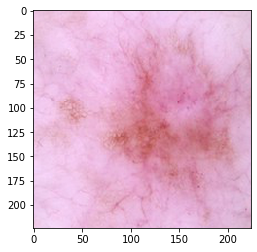

In [206]:
imagem_teste = '/content/gdrive/My Drive/UnB/TCC-1/TCC-1-dataset/dataset-split/dataset-test/dermatofibroma/10.jpg'

result = process_image(imagem_teste)
res = torch.from_numpy(result)
imshow(res)

## Function to make single predictions base on top5 most close match

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    image = process_image(image_path)
    image = torch.from_numpy(image)

    if train_on_gpu:
      model.cuda()
      image = image.cuda()
    image = image.float().unsqueeze(0)
    out = model.forward(image)
    logps = F.log_softmax(out)
    ps = torch.exp(logps)
    probs, classes = ps.topk(topk, dim=1)

    if train_on_gpu:
      probs = list(probs.squeeze(0).cpu().detach().numpy())
      classes = list(classes.squeeze(0).cpu().detach().numpy())

    else:
      probs = list(probs.squeeze(0).detach().numpy())
      classes = list(classes.squeeze(0).detach().numpy())
    idx_class_mapping = dict((v,k) for k,v in test_data.class_to_idx.items())
    classes = list(map(lambda x: idx_class_mapping[x], classes))

    return probs, classes


In [208]:
probs, classes = predict(imagem_teste, model_ft)
print(probs)
print(classes)

[0.5677406, 0.34506133, 0.08256749, 0.004574562, 2.4455296e-05]
['actinic-keratosis', 'dermatofibroma', 'basal-cell-carcinoma', 'squamous-cell-carcinoma', 'malignant-melanoma']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


## Load map number to name dict

In [209]:
skin_list = list(classes_skin.keys())
skin_list

['actinic-keratosis',
 'basal-cell-carcinoma',
 'dermatofibroma',
 'hemangioma',
 'intraepithelial-carcinoma',
 'malignant-melanoma',
 'melanocytic-nevus',
 'pyogenic-granuloma',
 'squamous-cell-carcinoma']

In [0]:
def plot_bar(image_path, model):
  result = process_image(image_path)
  res = torch.from_numpy(result)
  fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
  ax1 = imshow(res, ax1)
  probs, classes = predict(image_path,model)
  ax2.barh(np.arange(len(probs)), probs)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(len(probs)))
  v = list(skin_list)
  # classes = list(map(lambda x: skin_lesion_to_name[x], classes))
  ax2.set_yticklabels(classes, size='small');
  ax2.set_title('Class Probability')
  ax2.set_xlim(0, 1.1)
  plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


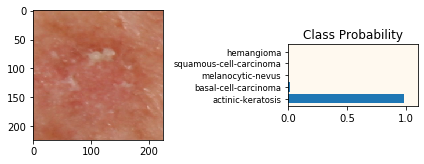

In [211]:
plot_bar('/content/gdrive/My Drive/UnB/TCC-1/TCC1-1-dataset-final/dataset_final/test/actinic-keratosis/1604.jpg', model_ft)

## Test routine for test_dir

In [0]:
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model_ft, 'cuda', testloader)

### Moreover, ROC and AUC metrics to avalute de model

In [213]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='macro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

Confusion matrix:
[[13  3  0  0  0  1  0  0  3]
 [ 0 73  2  0  1  4  1  1  2]
 [ 0  1 18  1  1  0  0  0  1]
 [ 0  0  0 16  0  1  0  2  0]
 [ 0  1  0  1  7  0  0  0  6]
 [ 0  1  0  2  1 60  2  0  3]
 [ 0  0  0  1  0  2 48  0  0]
 [ 0  0  0  1  0  0  0 10  0]
 [ 6 12  1  1  4  2  0  0 17]]
F1 score: 0.741553
Accuracy score: 0.784431


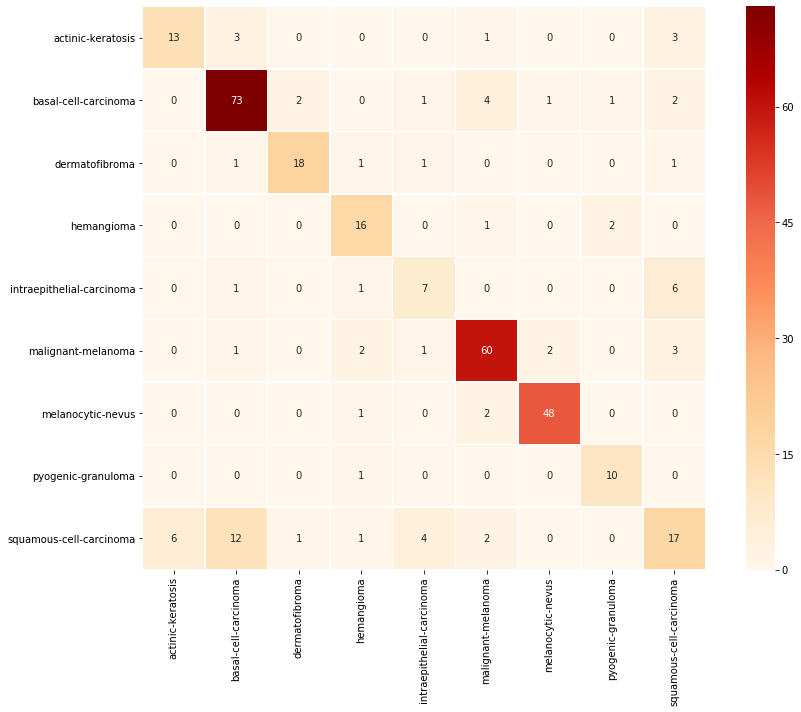

In [214]:
array= confusion_matrix(actuals, predictions)
df_cm = pd.DataFrame(array, index = [i for i in skin_list],
                  columns = [i for i in skin_list])
f, ax = plt.subplots(figsize=(13, 10))
sn.heatmap(df_cm, annot=True, square=True, linewidth=0.5, fmt="d", cmap="OrRd")
ax.set_ylim((9,0))
plt.tight_layout()
plt.savefig('cm_data_set_exp1.png' ,format='png', dpi=100)

In [215]:
classes_skin

{'actinic-keratosis': 0,
 'basal-cell-carcinoma': 1,
 'dermatofibroma': 2,
 'hemangioma': 3,
 'intraepithelial-carcinoma': 4,
 'malignant-melanoma': 5,
 'melanocytic-nevus': 6,
 'pyogenic-granuloma': 7,
 'squamous-cell-carcinoma': 8}

In [216]:
from sklearn.metrics import multilabel_confusion_matrix
import sklearn.metrics as skm

print(skm.classification_report(actuals, predictions))


              precision    recall  f1-score   support

           0       0.68      0.65      0.67        20
           1       0.80      0.87      0.83        84
           2       0.86      0.82      0.84        22
           3       0.70      0.84      0.76        19
           4       0.50      0.47      0.48        15
           5       0.86      0.87      0.86        69
           6       0.94      0.94      0.94        51
           7       0.77      0.91      0.83        11
           8       0.53      0.40      0.45        43

    accuracy                           0.78       334
   macro avg       0.74      0.75      0.74       334
weighted avg       0.78      0.78      0.78       334



In [217]:
multilabel_confusion_matrix(actuals, predictions)

array([[[308,   6],
        [  7,  13]],

       [[232,  18],
        [ 11,  73]],

       [[309,   3],
        [  4,  18]],

       [[308,   7],
        [  3,  16]],

       [[312,   7],
        [  8,   7]],

       [[255,  10],
        [  9,  60]],

       [[280,   3],
        [  3,  48]],

       [[320,   3],
        [  1,  10]],

       [[276,  15],
        [ 26,  17]]])

In [0]:
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt

def plot_roc(true, predictions, class_name, save_path=None):

  '''
  Function to plot roc curve
  - inputs
  true: label true data
  predictions: model predicitons for the input
  class_name: name of the analsis class
  save_path: will save if there is a valid path 
  '''
  fpr, tpr, thresholds = metrics.roc_curve(true, 
                                           predictions, 
                                           pos_label=1)
  print('-'*10)
  print('Classe: ', str(class_name))

  auc = "%.2f" % metrics.auc(fpr, tpr)
  # title = 'ROC Curve, AUC = '+ str(auc) + ' for ' + class_name
  title = 'ROC Curve for ' + class_name + ' with UAC = ' + str(auc) 
  plt.rcParams['axes.facecolor'] = '#FFF9EF'
  with plt.style.context(('seaborn-paper')):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, color='#8B0000',
            lw=2,
            label='ROC curve for {}'.format(class_name))
    ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title(title)
    plt.tight_layout()
    if save_path:
      plt.savefig(save_path+'/roc_curve_data_set_2{}.png'.format(class_name) ,format='png')
  
  return fig 

## ROC for intraepithelial-carcinoma

In [0]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            
            actuals.extend(target.view_as(prediction) == torch.from_numpy(np.array(which_class)))
            probabilities.extend(np.exp(output[:, torch.from_numpy(np.array(which_class))].cpu()))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

In [0]:
true = []
predicton = []
for i, class_name in enumerate(skin_list):
  actuals, class_probabilities = test_class_probabilities(model_ft, 'cuda', testloader, i)
  true.append(actuals)
  predicton.append(class_probabilities)

----------
Classe:  actinic-keratosis
----------
Classe:  basal-cell-carcinoma
----------
Classe:  dermatofibroma
----------
Classe:  hemangioma
----------
Classe:  intraepithelial-carcinoma
----------
Classe:  malignant-melanoma
----------
Classe:  melanocytic-nevus
----------
Classe:  pyogenic-granuloma
----------
Classe:  squamous-cell-carcinoma


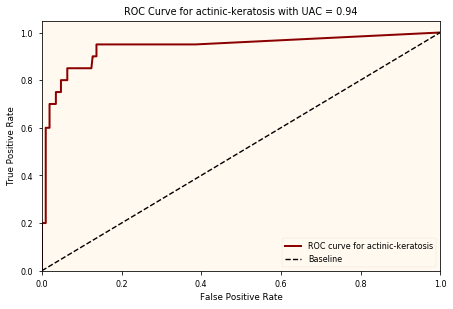

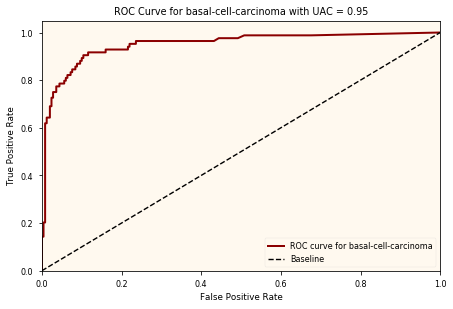

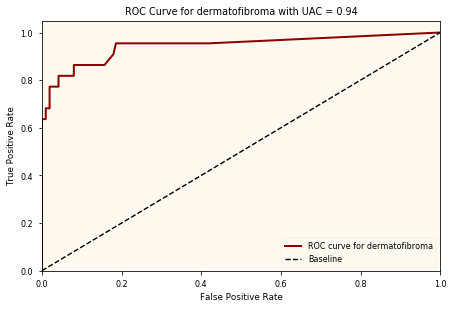

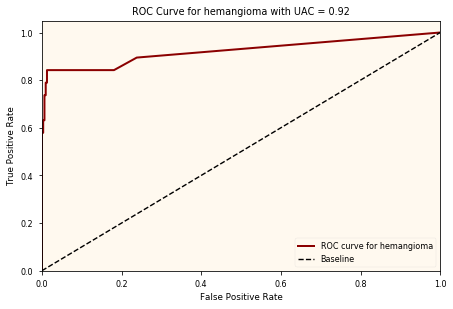

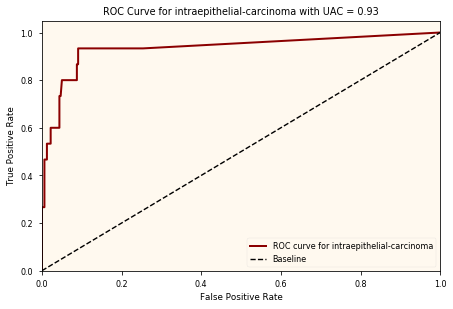

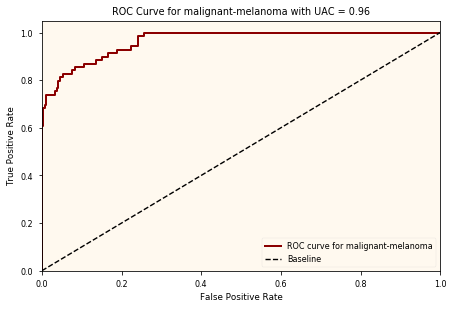

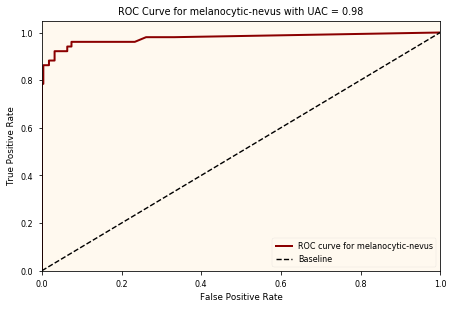

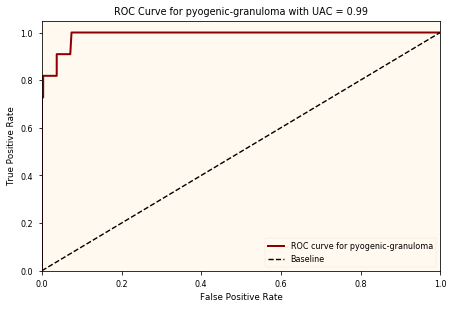

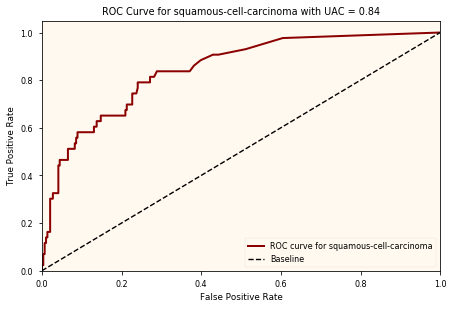

In [221]:
for i, skin_lesion in enumerate(skin_list):
  true_label = np.multiply(np.array(true[i]), 1)
  pred_label = np.multiply(np.array(predicton[i]), 1)
  plot_roc(true_label.round(), pred_label.round(), skin_lesion, '/content/gdrive/My Drive/UnB/TCC-1/TCC-1-dataset/imagens_exp6')

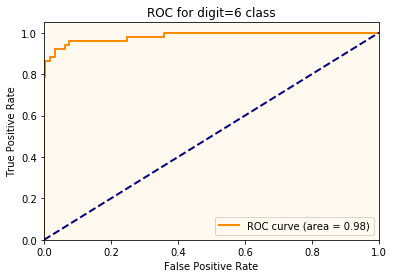

In [67]:
fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()

In [0]:
# 9: 'Wart' 
which_class = 9
actuals, class_probabilities = test_class_probabilities(model_ft, 'cuda', testloader, which_class)

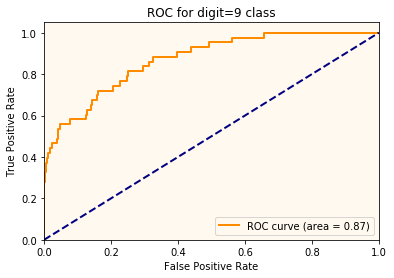

In [0]:
fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()

In [0]:
# 11: 'hemangioma' 
which_class = 11
actuals, class_probabilities = test_class_probabilities(model_ft, 'cuda', testloader, which_class)

IndexError: ignored

In [0]:
fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()

In [0]:
# 2: 
which_class = 2
actuals, class_probabilities = test_class_probabilities(model_ft, 'cuda', testloader, which_class)

In [0]:
fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()